# Imports

In [1]:
## Imports
import numpy as np
import math as m
import pylab as plt
import pickle
import sys
from matplotlib.animation import FuncAnimation
import time as t

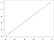

In [2]:
## Here because otherwise if you import plt and torch simultaneously, plt will crash the kernel in the future.
plt.figure(dpi=10)
plt.plot([0, 1])
plt.show()

In [3]:
import torch
import torchvision
from torch import nn

# Grading

## Forward Diffusion

In [4]:
def forward_diffusion(x0, T, delta):
    xs = [x0]
    for _ in range(T):
        xo = xs[-1]
        xs.append(xo + (delta/2)*-xo + m.sqrt(delta)*np.random.normal(0, 1))
    return xs

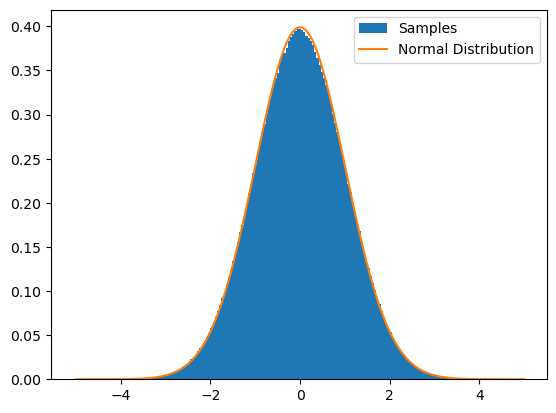

In [4]:
samples = forward_diffusion(10, 3000000, 0.05)[1000:]
plt.figure()
plt.hist(samples, density=True, bins=200, label="Samples")
mu = 0
sigma = 1
x = np.linspace(-5, 5, 1000)
pdf = (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, label='Normal Distribution')
plt.legend()
plt.show()

In [5]:
def approach_2(x0, T, delta):
    xs = [x0]
    for _ in range(T):
        xn = xs[-1] + m.sqrt(delta)*np.random.normal(0, 1)
        if np.exp((xs[-1]**2 - xn**2)/2) > np.random.rand():
            xs.append(xn)
    return xs

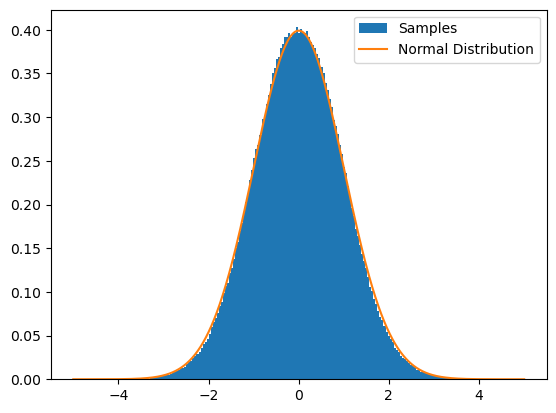

In [25]:
samples = approach_2(10, 1000000, 1)[1000:]
plt.figure()
plt.hist(samples, density=True, bins=200, label="Samples")
mu = 0
sigma = 1
x = np.linspace(-5, 5, 1000)
pdf = (1 / (1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, label='Normal Distribution')
plt.legend()
plt.show()

In [6]:
def approach_2_2(x0, T, d):
    xs = [x0]
    for _ in range(T):
        xo = xs[-1]
        xn = xo + (d/2)*-xo + np.random.normal(0, m.sqrt(d))
        A = np.exp(d*(xo - xn)*((-xo) + (-xn)) + ((d/2)**2)*(xo**2 - xn**2))
        if A > np.random.rand():
            xs.append(xn)
    return xs

Acceptance Rate = 0.999755


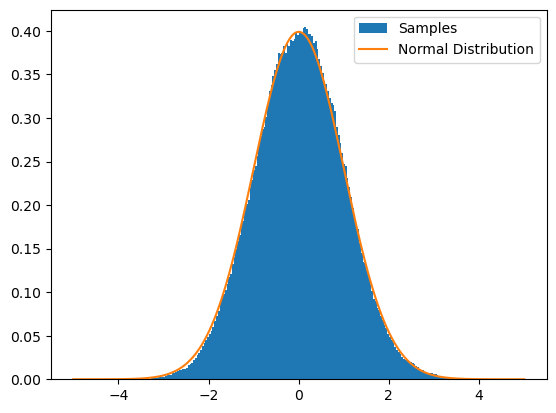

In [36]:
T = 1000000
samples = approach_2_2(1, T, 0.005)
print(f"Acceptance Rate = {len(samples)/T}")
plt.figure()
plt.plot()
plt.hist(samples, density=True, bins=200, label='Samples')
mu = 0
sigma = 1
x = np.linspace(-5, 5, 1000)
pdf = (1 / (1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, label='Normal Distribution')
plt.legend()
plt.show()

In [7]:
beta = np.linspace(0.0001, 0.02, 200,dtype=np.float32)

In [8]:
def forward_diffusion_2(x0, beta_t, timesteps):
    if timesteps > beta_t.shape[0]:
        print(f"Error: timesteps ({timesteps}) > len(beta_t) ({beta_t.shape[0]})")
        return
    B = beta_t
    xs = [x0]
    for i in range(timesteps):
        xo = xs[-1]
        xs.append(xo*np.sqrt(1-B[i]) + np.sqrt(B[i])*np.random.normal(0, 1))
    return xs

def forward_diffusion_3(x0, beta_t, timesteps):
    x = x0
    if timesteps > beta_t.shape[0]:
        print(f"Error: timesteps ({timesteps}) > len(beta_t) ({beta_t.shape[0]})")
        return
    B = beta_t
    for i in range(timesteps):
        x = x*np.sqrt(1-B[i]) + np.sqrt(B[i])*np.random.normal(0, 1)
    return x

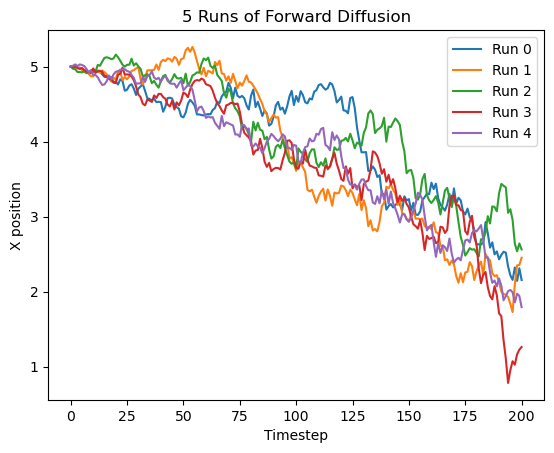

In [7]:
n = 5
plt.figure()
for i in range(n):
    run = forward_diffusion_2(np.ones(shape=[1])*5, beta, 200)
    plt.plot(run, label=f'Run {i}')
plt.legend()
plt.title(f"{n} Runs of Forward Diffusion")
plt.xlabel("Timestep")
plt.ylabel("X position")
plt.show()  

here


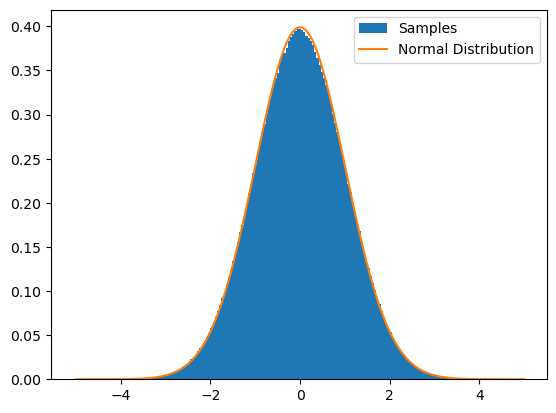

In [35]:
results = []
for i in range(10000):
    results.append(forward_diffusion_3(0, beta, 199))
print("here")
plt.figure()
plt.plot()
plt.hist(samples, density=True, bins=200, label='Samples')
mu = 0
sigma = 1
x = np.linspace(-5, 5, 1000)
pdf = (1 / (1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, label='Normal Distribution')
plt.legend()
plt.show()

In [9]:
def forward_diffusion_4(x0, beta_t, timesteps):
    if timesteps > beta_t.shape[0]:
        print(f"Error: timesteps ({timesteps}) > len(beta_t) ({beta_t.shape[0]})")
        return
    B = beta_t
    a = [1-b for b in B]
    a_T = np.prod(a[:timesteps])
    return np.sqrt(a_T)*x0 + np.sqrt(1-a_T)*np.random.normal(0, 1)

here


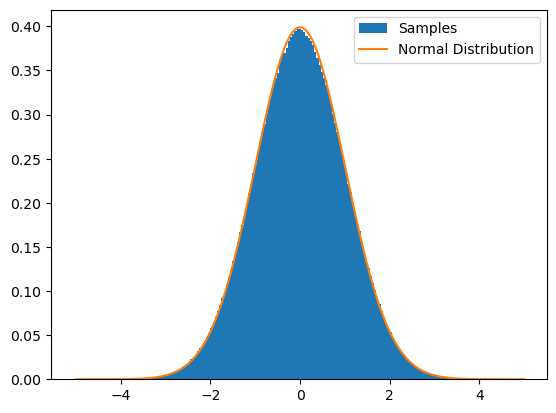

In [38]:
results = []
for i in range(10000):
    results.append(forward_diffusion_4(0, beta, 200))
print("here")
plt.figure()
plt.plot()
plt.hist(samples, density=True, bins=200, label='Samples')
mu = 0
sigma = 1
x = np.linspace(-5, 5, 1000)
pdf = (1 / (1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2)
plt.plot(x, pdf, label='Normal Distribution')
plt.legend()
plt.show()

## Undiffusing

In [14]:
beta = np.linspace(0.0001, 0.02, 200,dtype=np.float32)

def undiffuse(xt, beta_t, timestep, final_t, guess_function, net_guess=False):
    if timestep > beta_t.shape[0]:
        print(f"Error: timestep ({timestep}) > max B ({beta_t.shape[0]-1})")
        return
    xs = [np.copy(xt)]
    while timestep != final_t:
        a = [1-b for b in beta_t]
        a_T = np.prod(a[:timestep])
        s_T = (1-a[timestep-1])/np.sqrt(1-a_T)
        if timestep != final_t+1:
            a_T1 = np.prod(a[:timestep-1])
            B_T = ((1-a_T1)/(1-a_T))*beta_t[timestep-1]
            normal = np.sqrt(B_T)*np.random.normal(0, 1)
        else:
            normal = 0
        if net_guess:
            xs.append((1/np.sqrt(a[timestep-1]))*(xs[-1] - s_T * net(torch.tensor([float(xs[-1]),timestep])).detach().numpy()[0]) + normal)
        else:
            xs.append((1/np.sqrt(a[timestep-1]))*(xs[-1] - s_T * guess_function(xs[-1], a_T)) + normal)
        timestep -= 1
    return xs[::-1]

def guess_z(xt, a_T, x0=0.4):
    return (1/np.sqrt(1-a_T))*(xt-np.sqrt(a_T)*x0)

### Plots

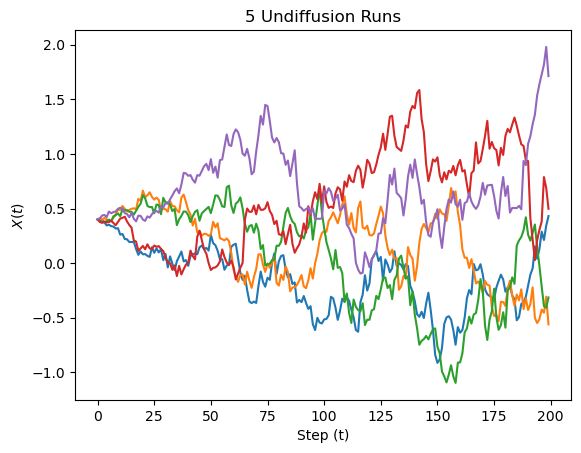

In [42]:
n = 5
x0 = 0.4
xts = [forward_diffusion_4(x0, beta, 200) for i in range(n)]
xs = [undiffuse(xt, beta, 199, 0, guess_z) for xt in xts]
plt.figure()
for x in xs:
    plt.plot(x)
plt.title("5 Undiffusion Runs")
plt.xlabel("Step (t)")
plt.ylabel(r"$X(t)$")
plt.show()


In [45]:
with open("undiffuse_xts.pkl", "rb") as fp:   # Unpickling
    xts = pickle.load(fp)
with open("undiffuse_x0s.pkl", "rb") as fp:   # Unpickling
    x0s = pickle.load(fp)

n = 500
x0 = 0.4
# xts = [forward_diffusion_4(x0, beta, 200) for i in range(n)]
# x0s = [undiffuse(xt, beta, 199, 0, guess_z)[0] for xt in xts]

# with open("undiffuse_xts.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts, fp)
# with open("undiffuse_x0s.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x0s, fp)

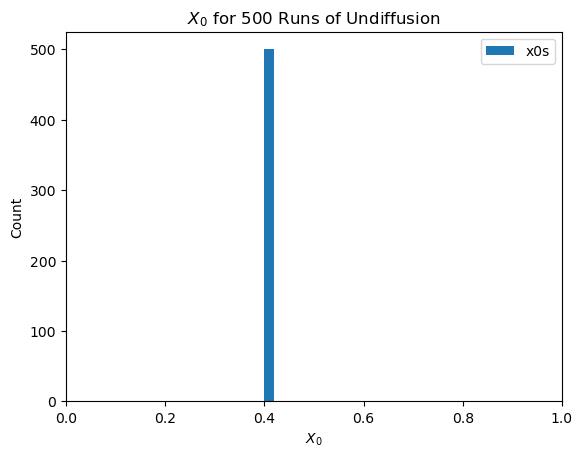

In [46]:
plt.figure()
plt.hist(x0s, density=False, bins=50, label='x0s')
plt.xlim(0, 1)
plt.legend()
plt.title(r"$X_0$ for 500 Runs of Undiffusion")
plt.xlabel(r"$X_0$")
plt.ylabel("Count")
plt.show()

In [47]:
with open("undiffuse_xts2.pkl", "rb") as fp:   # Unpickling
    xts2 = pickle.load(fp)
with open("undiffuse_x125s.pkl", "rb") as fp:   # Unpickling
    x125s = pickle.load(fp)
    
n = 1000
x0 = 0.4
# xts2 = [forward_diffusion_4(x0, beta, 125) for i in range(n*100)]
# xts_und = [forward_diffusion_4(x0, beta, 200) for i in range(n)]
# x125s = [undiffuse(xt, beta, 199, 125, guess_z)[0] for xt in xts_und]

# with open("undiffuse_xts2.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts2, fp)
# with open("undiffuse_x125s.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x125s, fp)

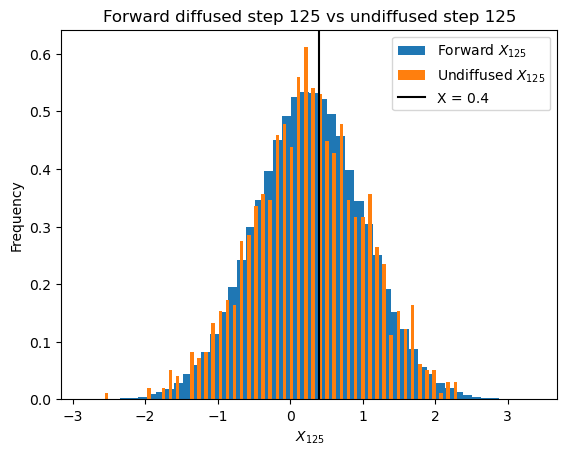

In [48]:
plt.figure()
plt.hist(xts2, density=True, bins=50, label=r'Forward $X_{125}$')
plt.hist(x125s, density=True, bins=50, rwidth=.5, label=r'Undiffused $X_{125}$')
plt.axvline(0.4, color='black', label = "X = 0.4")
# plt.xlim(0, 1)
plt.legend()
plt.title("Forward diffused step 125 vs undiffused step 125")
plt.xlabel(r"$X_{125}$")
plt.ylabel("Frequency")
plt.show()

### Functions for Double $X_0$

In [23]:
def sample_from_two(n, ps=[0.8, 0.2]):
    xs = [0.4, -0.6]
    if n == 1:
        return float(np.random.choice(xs, size=n, p=ps)[0])
    return np.random.choice(xs, size=n, p=ps)

def guess_z_2(xt, a_T):
    za = (1/np.sqrt(1-a_T))*(xt-np.sqrt(a_T)*0.4)
    zb = (1/np.sqrt(1-a_T))*(xt-np.sqrt(a_T)*(-0.6))
    ea = np.exp(-(za**2)/2)
    eb = np.exp(-(zb**2)/2)
    return (0.8*za*ea+0.2*zb*eb)/(0.8*ea+0.2*eb)

### Plots

[ 0.4 -0.6  0.4 -0.6 -0.6]


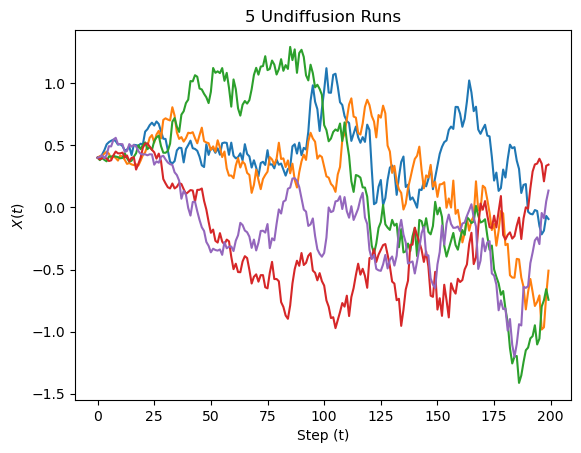

In [26]:
n = 5
x0s = sample_from_two(n)
print(x0s)
xts = [forward_diffusion_4(x0, beta, 200) for x0 in x0s]
xs = [undiffuse(xt, beta, 199, 0, guess_z_2) for xt in xts]
plt.figure()
for x in xs:
    plt.plot(x)
plt.title("5 Undiffusion Runs")
plt.xlabel("Step (t)")
plt.ylabel(r"$X(t)$")
plt.show()

In [63]:
with open("undiffuse_xts3.pkl", "rb") as fp:   # Unpickling
    xts3 = pickle.load(fp)
with open("undiffuse_x0s3.pkl", "rb") as fp:   # Unpickling
    x0s3 = pickle.load(fp)

n = 1000
# x0s = sample_from_two(n)
# xts3 = [forward_diffusion_4(x0, beta, 200) for x0 in x0s]
# x0s3 = [undiffuse(xt, beta, 199, 0, guess_z_2)[0] for xt in xts3]

# with open("undiffuse_xts3.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts3, fp)
# with open("undiffuse_x0s3.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x0s3, fp)

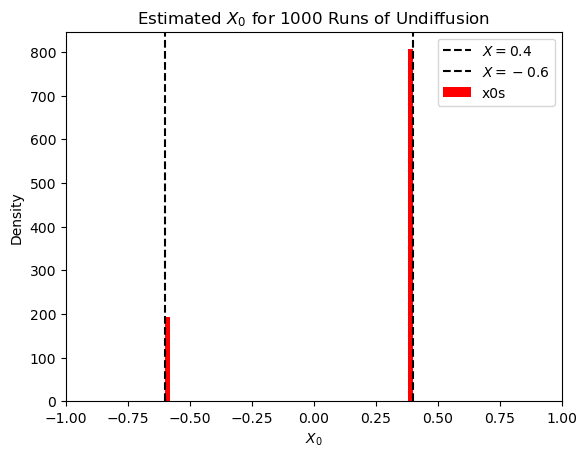

In [62]:
plt.figure()
plt.axvline(0.4, color='black', linestyle='--', label=r"$X=0.4$")
plt.axvline(-0.6, color='black', linestyle='--', label=r"$X=-0.6$")
plt.hist(x0s3, density=False, bins=50, label='x0s', color='red')
plt.xlim(-1, 1)
plt.title(r"Estimated $X_0$ for $1000$ Runs of Undiffusion")
plt.xlabel(r"$X_0$")
plt.ylabel("Density")
plt.legend()
plt.show()

In [66]:
with open("undiffuse_xts4.pkl", "rb") as fp:   # Unpickling
    xts4 = pickle.load(fp)
with open("undiffuse_x125s4.pkl", "rb") as fp:   # Unpickling
    x125s4 = pickle.load(fp)

n = 5000
# x0s = sample_from_two(n)
# x0s_extra = sample_from_two(n*25)
# xts4 = [forward_diffusion_4(x0, beta, 125) for x0 in x0s_extra]
# xts_und = [forward_diffusion_4(x0, beta, 200)  for x0 in x0s]
# x125s4 = [undiffuse(xt, beta, 199, 125, guess_z_2)[0] for xt in xts_und]

# with open("undiffuse_xts4.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts4, fp)
# with open("undiffuse_x125s4.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x125s4, fp)

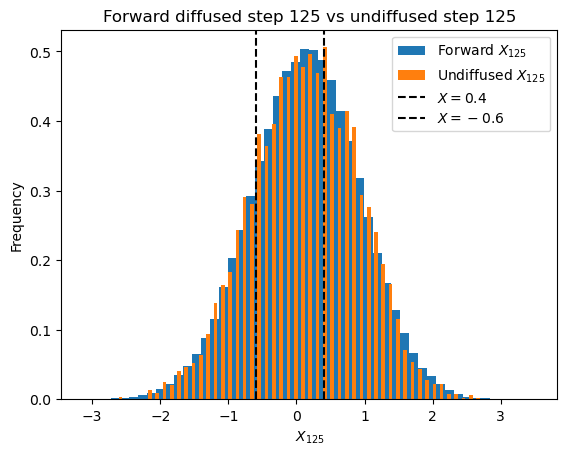

In [67]:
plt.figure()
plt.hist(xts4, density=True, bins=50, label=r'Forward $X_{125}$')
plt.hist(x125s4, density=True, bins=50, rwidth=.5, label=r'Undiffused $X_{125}$')
plt.axvline(0.4, color='black', linestyle='--', label=r"$X=0.4$")
plt.axvline(-0.6, color='black', linestyle='--', label=r"$X=-0.6$")
plt.legend()
plt.title("Forward diffused step 125 vs undiffused step 125")
plt.xlabel(r"$X_{125}$")
plt.ylabel("Frequency")
plt.show()

## Torch Training

In [12]:
def forward_diffusion_fast(x0, beta_t, timesteps):
    if timesteps > beta_t.shape[0]:
        print(f"Error: timesteps ({timesteps}) > len(beta_t) ({beta_t.shape[0]})")
        return
    B = beta_t
    a = [1-b for b in B]
    a_T = np.prod(a[:timesteps])
    noise = np.random.normal(0, 1)
    xt = np.sqrt(a_T)*x0 + np.sqrt(1-a_T)*noise
    return xt, noise

In [13]:
## Takes array of data and returns it window averaged
def rolling_avg(arr, window):
    to_return = []
    for i in range(len(arr)):
        lower = int(i-window/2)
        upper = int(i+window/2)
        if lower < 0: lower = 0
        if upper >= len(arr): upper = len(arr)-1
        to_return.append(sum(arr[lower:upper])/(upper-lower))          
    return to_return

In [32]:
n_input, n_hidden, n_out = 2, 15, 1

# net = nn.Sequential(nn.Linear(n_input, n_hidden),
#                       nn.ReLU(),
#                       nn.Linear(n_hidden, n_hidden),
#                       nn.ReLU(),
#                       nn.Linear(n_hidden, n_out),
#                       )
# net(torch.tensor([3.0,4]))
# net.load_state_dict(torch.load('net1.pt'))

net = nn.Sequential(nn.Linear(n_input, n_hidden*3),
                      nn.ReLU(),
                      nn.Linear(n_hidden*3, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      )
net(torch.tensor([3.0,4]))
net.load_state_dict(torch.load('net2.pt'))

with open("net2_losses.pkl", "rb") as fp:   # Unpickling
    losses = pickle.load(fp)

In [48]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

total_steps = 200000
start_time = t.time()

losses = []
for step in range(0, total_steps):
    opt.zero_grad()
    x0 = torch.tensor(sample_from_two(1, ps=[0.5, 0.5]))
    this_t = np.random.choice(range(1, 201))

    data, noise = forward_diffusion_fast(x0, beta, this_t)
    noisy_data = torch.tensor([data.item(), this_t]).float()  # include the time for the data
    noise = torch.tensor([noise])

    prediction = net(noisy_data)
    loss = loss_fn(noise, prediction)
    loss.backward()
    losses.append(loss.item())
    
    if step % 100 == 0:
        elapsed_time = t.time() - start_time
        time_per_step = elapsed_time / (step + 1)
        remaining_steps = total_steps - step - 1
        remaining_time = remaining_steps * time_per_step

        sys.stdout.write('\r')
        sys.stdout.write(f"Step {step}/{total_steps} completed. Loss: {loss.item():.6f}. Time remaining: {remaining_time:.2f} seconds.")
        sys.stdout.flush()

    opt.step()
sys.stdout.write('\r')
sys.stdout.write(f"Step {total_steps}/{total_steps} completed. Loss: {loss.item():.6f}. Time remaining: 0 seconds.")
sys.stdout.flush()

Step 200000/200000 completed. Loss: 0.007411. Time remaining: 0 seconds.ds....

In [58]:
torch.save(net.state_dict(), 'net4.pt')
with open("net4_losses.pkl", "wb") as fp:   #Pickling
    pickle.dump(losses, fp)

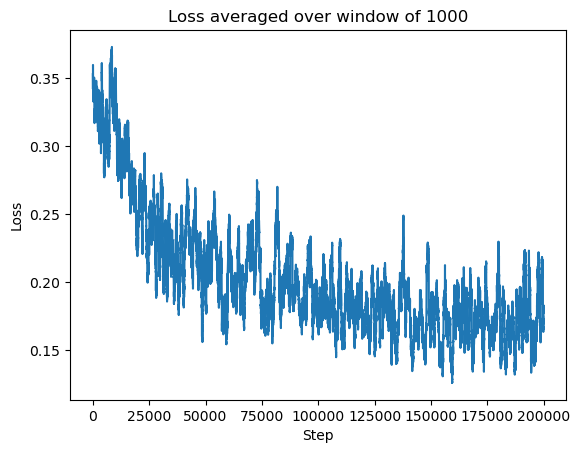

In [30]:
window = 1000
plt.figure()
plt.title(f"Loss averaged over window of {window}")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(rolling_avg(losses, window))
plt.show()

[-0.6, -0.6, -0.6, -0.6, -0.6]


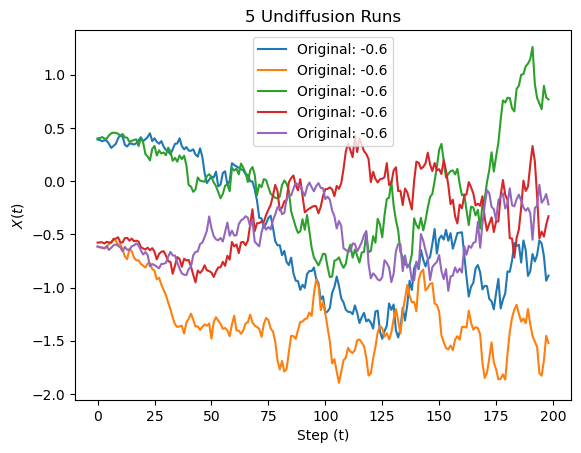

In [50]:
n = 5
step = 199
# x0s = sample_from_two(n)
x0s = [-0.6, -0.6, -0.6, -0.6, -0.6]
print(x0s)
xts = [forward_diffusion_4(x0, beta, step) for x0 in x0s]
xs = [undiffuse(xt, beta, step-1, 0, _, net_guess=True) for xt in xts]
plt.figure()
for i in range(n):
    plt.plot(xs[i],label=f"Original: {x0s[i]}")
plt.title("5 Undiffusion Runs")
plt.xlabel("Step (t)")
plt.ylabel(r"$X(t)$")
plt.legend()
plt.show()

In [33]:
with open("undiffuse_xts5.pkl", "rb") as fp:   # Unpickling
    xts5 = pickle.load(fp)
with open("undiffuse_x0s5.pkl", "rb") as fp:   # Unpickling
    x0s5 = pickle.load(fp)

n = 250
# x0s = sample_from_two(n, [0.4, 0.6])
# xts5 = [forward_diffusion_4(x0, beta, 200) for x0 in x0s]
# x0s5 = [undiffuse(xt, beta, 200, 0, _, net_guess=True)[0] for xt in xts5]

# with open("undiffuse_xts7.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts5, fp)
# with open("undiffuse_x0s7.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x0s5, fp)

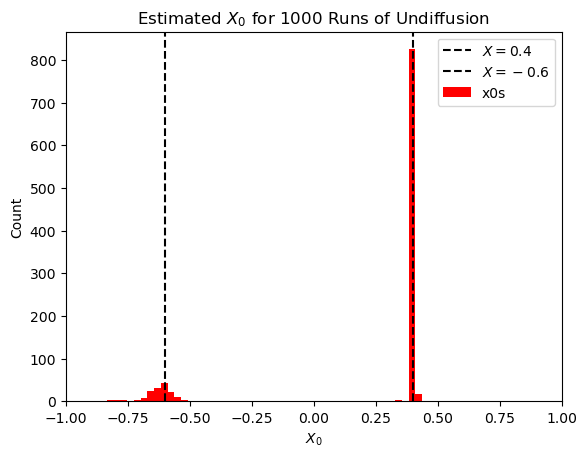

In [35]:
plt.figure()
plt.axvline(0.4, color='black', linestyle='--', label=r"$X=0.4$")
plt.axvline(-0.6, color='black', linestyle='--', label=r"$X=-0.6$")
plt.hist(x0s5, density=False, bins=50, label='x0s', color='red')
plt.xlim(-1, 1)
plt.title(r"Estimated $X_0$ for $1000$ Runs of Undiffusion")
plt.xlabel(r"$X_0$")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
# with open("undiffuse_xts6.pkl", "rb") as fp:   # Unpickling
#     xts6 = pickle.load(fp)
# with open("undiffuse_x125s6.pkl", "rb") as fp:   # Unpickling
#     x125s6 = pickle.load(fp)

n = 1000
x0s = sample_from_two(n, [0.5, 0.5])
x0s_extra = sample_from_two(n*25)
xts6 = [forward_diffusion_4(x0, beta, 125) for x0 in x0s_extra]
xts_und = [forward_diffusion_4(x0, beta, 200)  for x0 in x0s]
x125s6 = [undiffuse(xt, beta, 199, 125, guess_z_2)[0] for xt in xts_und]

# with open("undiffuse_xts6.pkl", "wb") as fp:   #Pickling
#     pickle.dump(xts6, fp)
# with open("undiffuse_x125s6.pkl", "wb") as fp:   #Pickling
#     pickle.dump(x125s6, fp)

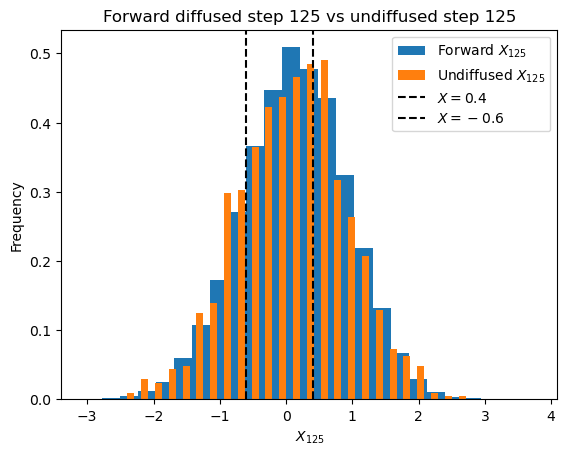

In [16]:
plt.figure()
plt.hist(xts6, density=True, bins=25, label=r'Forward $X_{125}$')
plt.hist(x125s6, density=True, bins=25, rwidth=.5, label=r'Undiffused $X_{125}$')
plt.axvline(0.4, color='black', linestyle='--', label=r"$X=0.4$")
plt.axvline(-0.6, color='black', linestyle='--', label=r"$X=-0.6$")
plt.legend()
plt.title("Forward diffused step 125 vs undiffused step 125")
plt.xlabel(r"$X_{125}$")
plt.ylabel("Frequency")
plt.show()

Step 199/200 completed

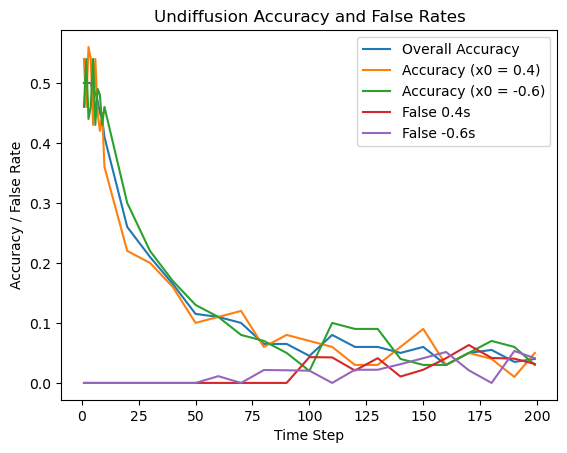

In [108]:
## Function written by ChatGPT (GPT-4) to measure accuracy of undiffusion by timestep undiffusing from
def test_undiffusion_accuracy(net, beta, n_trials=100, threshold=0.1):
    time_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199]
    overall_accuracies = []
    accuracies_04 = []
    accuracies_m06 = []
    false_04s = []
    false_m06s = []

    for t in time_steps:
        sys.stdout.write('\r')
        sys.stdout.write(f"Step {t}/{200} completed")
        sys.stdout.flush()
        
        correct_04 = 0
        correct_m06 = 0
        false_04 = 0
        false_m06 = 0

        for _ in range(n_trials):
            x0 = np.random.choice([0.4, -0.6])
            xt = forward_diffusion_4(x0, beta, t)
            xs = undiffuse(xt, beta, t-1, 0, _, net_guess=True)
            predicted_x0 = xs[-1]

            if np.abs(predicted_x0 - x0) < threshold:
                if x0 == 0.4:
                    correct_04 += 1
                else:
                    correct_m06 += 1
            elif np.abs(predicted_x0 - 0.4) < threshold:
                false_04 += 1
            elif np.abs(predicted_x0 + 0.6) < threshold:
                false_m06 += 1

        overall_accuracy = (correct_04 + correct_m06) / (2 * n_trials)
        accuracy_04 = correct_04 / n_trials
        accuracy_m06 = correct_m06 / n_trials
        false_rate_04 = false_04 / (n_trials - correct_04)
        false_rate_m06 = false_m06 / (n_trials - correct_m06)

        overall_accuracies.append(overall_accuracy)
        accuracies_04.append(accuracy_04)
        accuracies_m06.append(accuracy_m06)
        false_04s.append(false_rate_04)
        false_m06s.append(false_rate_m06)

    plt.plot(time_steps, overall_accuracies, label='Overall Accuracy')
    plt.plot(time_steps, accuracies_04, label='Accuracy (x0 = 0.4)')
    plt.plot(time_steps, accuracies_m06, label='Accuracy (x0 = -0.6)')
    plt.plot(time_steps, false_04s, label='False 0.4s')
    plt.plot(time_steps, false_m06s, label='False -0.6s')
    
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy / False Rate')
    plt.title('Undiffusion Accuracy and False Rates')
    plt.legend()
    plt.show()

test_undiffusion_accuracy(net, beta)